# Análise de Imóveis em SP

## Introdução

Com o advento da tecnologia na sociedade, os dados gerados passaram a crescer de forma exponencial, surgindo assim a necessidade de analisá-los para ser possível entender melhor as relações do ser humano com a tecnologia. Desse modo, o WebScrapping é uma das formas de obter dados de fontes onlines mais utilizadas hoje em dia. Essa técnica é responsável por captar dados estruturados de sites online de maneira automática e é muito utilizada para treinar modelos de tomada de decisão.

## Problema

O quinto andar é um dos sites mais utilizados para compra e aluguel de imóveis no Brasil. A partir dele, um scrapping será realizado para pegar informações sobre imóveis de diferentes regiões de São Paulo. Com isso, modelos de machine learning serão aplicados para tentar prever o preço do imóvel a partir da região dele.

In [3]:
from bs4 import BeautifulSoup
import pandas as pd
from selenium import webdriver
from selenium.webdriver.support.ui import WebDriverWait
from webdriver_manager.chrome import ChromeDriverManager
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.by import By
from selenium.webdriver.support import expected_conditions as EC
import time
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sn



## Extração de Dados

A funcão abaixo é responsável por realizar o scrapping do Quinto Andar de acordo com a região desejada. Para isso, utilizou-se da Biblioteca Selenium e foram coletados os seguintes dados: enderecos, regioes, valores, metragem, número de quartos e número de vagas.

In [4]:
def get_dataset(url, file_name):
    
    print("Getting page url")
    driver = webdriver.Chrome(service=Service(ChromeDriverManager().install()))
    driver.set_page_load_timeout(60)
    driver.get(url)
    
    WebDriverWait(driver, 20).until(EC.visibility_of_element_located((By.CLASS_NAME, "sc-ftvSup.xPMpo")))
    
    print("Loading more information")

       
    print("Collecting data")
    enderecos = []
    regioes = []
    tipos_valores = []
    outras_informacoes = []
    for i in range(20):
        enderecos.append([x.text for x in driver.find_elements(By.CSS_SELECTOR, 'span[data-testid="house-card-address"]')])
        regioes.append([x.text for x in driver.find_elements(By.CSS_SELECTOR, 'span[data-testid="house-card-region"]')])
        tipos_valores.append([x.text for x in  driver.find_elements(By.CLASS_NAME, 'sc-gsnTZi.iRsaMY.sc-crXcEl.jddosl.CozyTypography')])
        outras_informacoes.append(driver.find_elements(By.CSS_SELECTOR, 'small[data-testid="house-card-area"]'))
        WebDriverWait(driver, 20).until(EC.visibility_of_element_located((By.CLASS_NAME, "sc-ftvSup.xPMpo")))
        elem = driver.find_elements(By.CLASS_NAME, "sc-ftvSup.xPMpo")
        elem[0].click()
        time.sleep(1)
        print(i)


    outras_informacoes_clean = []
    for i in outras_informacoes:
        for j in i:
            outras_informacoes_clean.append(j.text)

    enderecos = [item for sublist in enderecos for item in sublist]
    regioes = [item for sublist in regioes for item in sublist]
    tipos_valores = [item for sublist in tipos_valores for item in sublist]

    tipo = []
    valores = []

    for i in range(len(tipos_valores)):
        if tipos_valores[i].startswith("R$"):
            valores.append(tipos_valores[i])
        else:
            tipo.append(tipos_valores[i])
    metragem = []
    n_quartos = []
    n_vagas = []
    for info in outras_informacoes_clean:
        splited_info  = info.split('•')
        metragem.append(int(splited_info[0].strip('m² ')))
        n_quartos.append(int(splited_info[1].strip(" quartos ")))
        n_vagas.append(int((splited_info[2].strip(" vagas "))))
    valores = [item.strip("R$ ").replace(".","")  for item in valores]
    regioes = [item.strip("R$ ").replace(".","") for item in regioes]
    
    print("Building the dataset")

    real_state = {"tipo": tipo, "enderecos" : enderecos, "regioes" :  regioes, "valores" : valores, "metragem" : metragem, "n_quartos" : n_quartos, "n_vagas" : n_vagas}
    df = pd.DataFrame(real_state)
    df.to_csv(file_name, index=False)
    
    print("Done")


### Obtendo os datasets

Os imóveis foram divididos em quatro principais regiões: Pinheiros, Vila Olímpia, Jardim Paulista e Jardim Europa:

In [5]:
regioes = ["vila-olimpia", "jardim-paulista", "jardim-europa", "pinheiros"]
for regiao in regioes:
    file_name= f"real_state_{regiao}.csv"
    if not os.path.exists(file_name):
        get_dataset(f'https://www.quintoandar.com.br/comprar/imovel/{regiao}-sao-paulo-sp-brasil', file_name)


In [6]:
df_pinheiros = pd.read_csv("real_state_pinheiros.csv")
df_vila_olimpia= pd.read_csv("real_state_vila-olimpia.csv")
df_jardim_paulista = pd.read_csv("real_state_jardim-paulista.csv")
df_jardim_europa = pd.read_csv("real_state_jardim-europa.csv")

In [7]:
df = pd.concat([df_pinheiros, df_vila_olimpia, df_jardim_paulista, df_jardim_europa], axis=0)

In [8]:
df = df.drop_duplicates()

In [11]:
df.head()

,tipo,enderecos,regioes,valores,metragem,n_quartos,n_vagas
0,Apartamento,Rua Simão Álvares,"Pinheiros, São Paulo",1250000,85,2,2
1,Apartamento,Rua Doutor Virgílio de Carvalho Pinto,"Pinheiros, São Paulo",820000,44,2,1
2,Apartamento,Rua Doutor Virgílio de Carvalho Pinto,"Pinheiros, São Paulo",1380000,110,3,1
3,Apartamento,Rua Capote Valente,"Pinheiros, São Paulo",780000,69,2,2
4,Apartamento,Rua Joaquim Antunes,"Pinheiros, São Paulo",850000,65,2,1


## Análise

### Observando os valores dos imóveis por região:

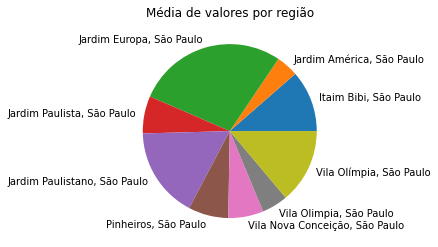

In [8]:
reg = df.groupby(['regioes'])['valores'].mean()
plt.title("Média de valores por região")
plot = plt.pie(reg, labels=reg.index)

### Treinando Modelos

In [9]:
df = df.drop(columns=["enderecos"] )

O OneHotEncoder foi utilizado para transformar as variáveis categóricas em um array numérico:

In [10]:
ohe = OneHotEncoder()
transformed = ohe.fit_transform(df[['tipo']])
df = df.drop(columns=['tipo'])
df[ohe.categories_[0]] = transformed.toarray()

In [11]:
ohe = OneHotEncoder()
transformed_2 = ohe.fit_transform(df[['regioes']])
df = df.drop(columns=['regioes'])
df[ohe.categories_[0]] = transformed_2.toarray()

Dividindo entre Treinamento e Teste:

In [12]:
X = df.drop(columns=["valores"])
y = df.valores
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


Dois modelos diferentes foram aplicados: A regressão linear e a Random Forest. Pode-se observar os resultados abaixo:

In [13]:
linear_regression = LinearRegression()

linear_regression.fit(X_train, y_train)

y_pred = linear_regression.predict(X_test)

In [14]:
r2 = r2_score(y_test, y_pred)

print("R-squared Score:", r2)

R-squared Score: 0.44783179823832087


In [15]:
rf = RandomForestRegressor(n_estimators=10, random_state=10)
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)
r2 = r2_score(y_test, y_pred)

print("R-squared Score:", r2)

R-squared Score: 0.749540509891879


## Conclusão

Desse modo, é possível concluir que o modelo feito a partir da regressão linear não pode ser considerado bom devido ao R<sup>2</sup> muito baixo, indicando que a previsão não explica mais da metade das variações. Já a RandomForest foi capaz de entregar resultados mais interessantes, com um  R<sup>2</sup> superior a 70%, indicando que o modelo possui um bom poder explicativo das variações das variáveis dependentes.